In [54]:
import pandas as pd
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
import random
import copy
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding
from PIL import Image, ImageFilter
import joblib, pickle
import gc


In [6]:
image_size = 64
path = 'datasets/anime_faces/'
sample_size = 10000

# List all files in the folder
image_files = os.listdir(path)

# Choose 100 random images from the list
random_images = random.sample(image_files, sample_size)
train_images = np.zeros((sample_size, image_size, image_size, 3))

for i, image in enumerate(random_images):
    img = Image.open(path + image)
    img = img.resize((image_size, image_size))
    train_images[i] = np.array(img)
    train_images[i] = train_images[i] / 255.0


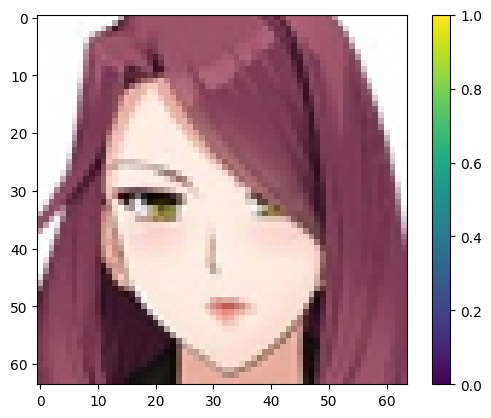

In [3]:
plt.figure()
plt.imshow(train_images[2])
plt.colorbar()
plt.show()




In [41]:
latent_dim = 10

rf = RandomForestRegressor(n_estimators=150, max_depth=10, random_state=0, n_jobs=-1, max_samples=0.2, min_samples_leaf=5)
scaler = MinMaxScaler()

# projection = Isomap(n_neighbors=10, n_components=latent_dim)
#projection = PCA(n_components=latent_dim)
#projection = SpectralEmbedding(n_components=latent_dim, n_neighbors=10, random_state=42, n_jobs=-1)

projection = KernelPCA(n_components=latent_dim, kernel='cosine', n_jobs=-1)
y = train_images.reshape(-1, image_size * image_size * 3).copy()
X = projection.fit_transform(y)
X = scaler.fit_transform(X)

print(X.shape, y.shape)
print('Fitting Random Forest Encoder')

gc.collect()

rf.fit(X, y)

(10000, 10) (10000, 12288)
Fitting Random Forest Encoder


RandomForestRegressor(max_depth=10, max_samples=0.2, min_samples_leaf=5,
                      n_estimators=150, n_jobs=-1, random_state=0)

In [45]:
model_filename = 'anime_model_light2'
joblib.dump(rf, model_filename)

RandomForestRegressor(max_depth=10, max_samples=0.2, min_samples_leaf=5,
                      n_estimators=150, n_jobs=-1, random_state=0)


['anime_model_light2']

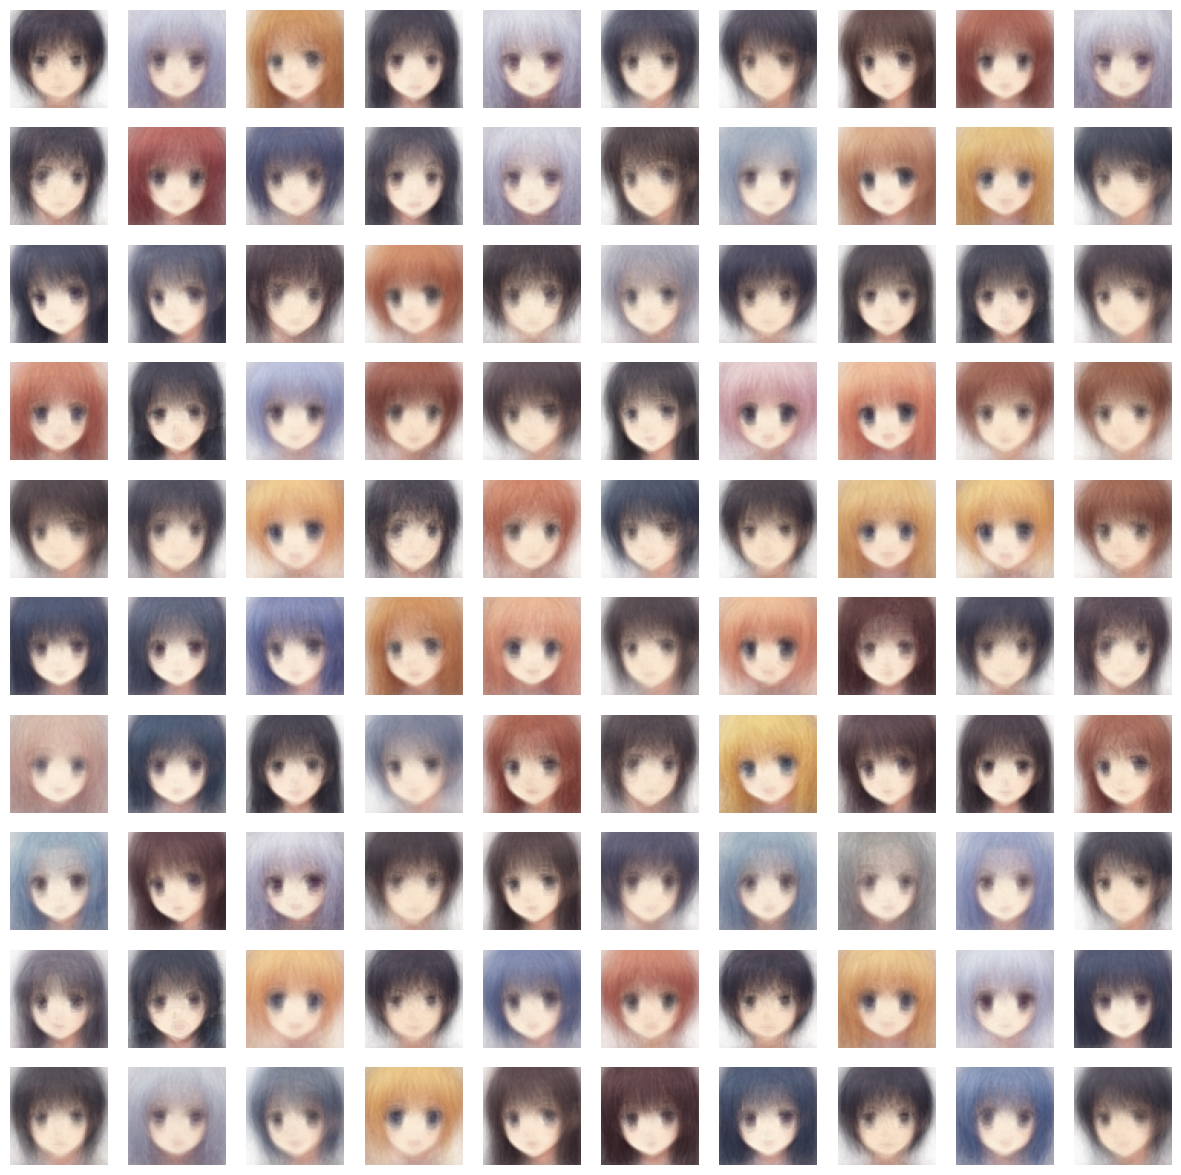

In [57]:

m = 100
threshold = 80
std_dev = 0.1

cov_matrix = np.identity(latent_dim) * std_dev
#input = np.array([[np.random.multivariate_normal(random.choice(X), cov_matrix)] for i in range(m)]).reshape(m, -1)
input = np.array([[random.uniform(0, 1) for j in range(latent_dim)] for i in range(m)])

y_pred = rf.predict(input)
y_pred = y_pred.reshape(m, image_size, image_size, 3)
pil_img = [Image.fromarray(np.uint8(img*255)) for img in y_pred]
sharp_img = [pil_img.filter(ImageFilter.SHARPEN) for pil_img in pil_img]
y_pred = [np.array(pil_img)/255 for pil_img in sharp_img]

fig, axs = plt.subplots(m//10, 10, figsize=(15, 15))
axs = axs.flatten()
# Plot data on the subplots
for i in range(m):
    axs[i].imshow(y_pred[i])
    axs[i].axis('off')  # Turn off axis labels and ticks


